## Setting Up the Libs and Marmousi2 Configurations

In [1]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import deepwave
import os
from timeit import default_timer as timer
import scipy.io as spio
import math
import numpy as np
from utils.utils import *
from torch import optim
from IPython.core.debugger import set_trace 
import random
torch.manual_seed(0)
random.seed(0)

####################################################
####   MAIN PARAMETERS FOR FORWARD MODELING         ####
####################################################

peak_freq = 5.                    # central frequency
peak_source_time = 1 / peak_freq  # the time (in secs) of the peak amplitude
dx        = 30.0                  # step interval along x/z direction
dt        = 0.003                 # time interval (e.g., 3ms)
num_dims  = 2                     # dimension of velocity model
nz        = 117                   # model shape of z dimension (depth) Marmousi2
ny        = 567                   # model shape of y dimension Marmousi2
vmodel_dim = np.array([nz, ny])

total_t   = 6.                      # totle sampling time (unit: s)
nt        = int(total_t / dt)       # number of time sampling points
num_shots = 30                      # nunmber of shots
num_sources_per_shot = 1            # number of sources per shot
num_receivers_per_shot = 567        # number of receivers per shot
source_spacing = np.floor(dx * ny / (num_shots+1))                         # space intervel between neigbouring sources
receiver_spacing = np.floor(dx * ny / (num_receivers_per_shot +1))         # space intervel between neigbouring receivers
source_depth = 0                # the index depth of sources, default is 0
receiver_depth = 0              # the index depths of receivers, default is 0
order          = 8              # precision order of finite difference in space domain
pml_width  = [0,10,10,10,0,0]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)

fwi_lr            = 10        # learning rate for updating the model.
fwi_batch         =   30      # number of batches for FWI.
fwi_num_epochs    = 800       # number of FWI iteration.
sim_lr            = 1*1e-5    # learning rate for Soamese network.
survey_pad = None
savepoch = 50                 # Saving models each 50 FWI iterations


/home/sadalyom/.conda/envs/FWIGAN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##   Check Cuda Device 


In [2]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
device

device(type='cuda')

## Creating Data Pathes

In [3]:
 
data_path = 'data/mar_big_117_567.bin'
initfile = 'data/mar_big_initmodel.mat'
initsafile = 'data/mar_big_initsource.mat'
fwi_result = 'results/marmousifwi/'

# Loading the true model
model_true = loadtruemodel(data_path, num_dims, vmodel_dim).to(device)
model, model_init = loadinitmodel(initfile,device)
# The model will be updated during FWI
model = torch.nn.Parameter(model)
# Creating source and reciver locations
x_s, x_r = createSR(num_shots, num_sources_per_shot, num_receivers_per_shot, num_dims, source_spacing, receiver_spacing,source_depth,receiver_depth)
x_s, x_r = x_s.to(device), x_r.to(device)
# Source Amplitude
source_amplitudes_init, source_amplitudes_true = loadinitsource(initsafile,device)
source = source_amplitudes_init.repeat(1,num_shots, num_sources_per_shot)
# receiver Amplitude
receiver_amplitudes = createdata(model_true,dx,source, \
                                x_s,x_r,dt,pml_width,order, \
                                 survey_pad,device).to(device)
receiver_amplitudes_true = receiver_amplitudes
rcv_amps_true = receiver_amplitudes_true.clone()

## Plotting the inital and true model


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


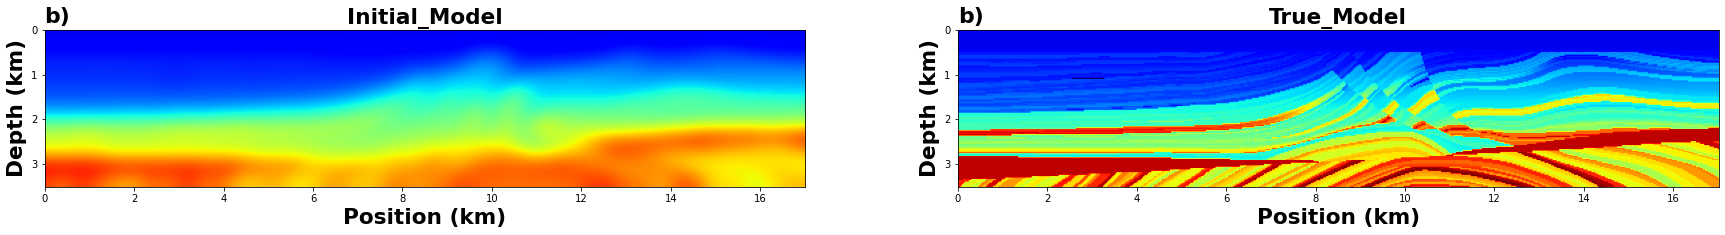

In [5]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3, 4])
box_min = 1140
box_max = 4700

f, ax = plt.subplots(1,2,figsize=(30, 13))
plt.rc('font', **font)


im = ax[0].imshow(model_init, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model_init.shape[1] * dx / 1000, model_init.shape[0] * dx / 1000, 0])
ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'b)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

model1 = model_true.detach().cpu().numpy()
im = ax[1].imshow(model1, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model1.shape[1] * dx / 1000, model1.shape[0] * dx / 1000, 0])
ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('True_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 


plt.show()

## Setting Up the Siamese and Optimizers

In [6]:
from torchsummary import summary
from Model.Module22_6 import *
import  torch


#Learning Schedule
def lr_lambda(epoch):
    return 1/2


### optimizer for the velocity model
optimizer = optim.Adam([{'params': model, 'lr':fwi_lr, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])

#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)


# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.99), \
                    eps=1e-6, weight_decay=0)

scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

summary(netD,[(3,nt,num_receivers_per_shot),(3,nt,num_receivers_per_shot)])


############## Init  ################# 
SNR = 0.0
SSIM = 0.0
Loss = 0.0
ERROR = 0.0




Number of netD params: 1519
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 3, 2000, 567]              84
         LeakyReLU-2         [-1, 3, 2000, 567]               0
            Conv2d-3         [-1, 3, 2000, 567]              84
         LeakyReLU-4         [-1, 3, 2000, 567]               0
            Conv2d-5         [-1, 3, 2000, 567]              84
         LeakyReLU-6         [-1, 3, 2000, 567]               0
            Conv2d-7         [-1, 4, 2000, 567]             112
         LeakyReLU-8         [-1, 4, 2000, 567]               0
            Conv2d-9         [-1, 4, 2000, 567]             112
        LeakyReLU-10         [-1, 4, 2000, 567]               0
           Conv2d-11         [-1, 3, 2000, 567]              84
        LeakyReLU-12         [-1, 3, 2000, 567]               0
           Conv2d-13         [-1, 3, 2000, 567]              84
        Lea

## Main SiameseFWI

In [9]:
 
import torch.nn.functional as F
# Starting the FWI loop.
global model_true, source_amplitudes_init, SNR, SSIM, Loss, ERROR

import torch.fft





t_start = time.time()
model_true = model_true.view(nz,ny)
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
criterion = nn.MSELoss()
for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizers to zero grad.
        optimizer.zero_grad()
        netD.train()                
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        prop = deepwave.scalar.Propagator({'vp': model},dx,pml_width, \
                                          order,survey_pad)
        batch_src_amps = source_amplitudes_init.repeat(1, num_shots_per_batch, 1)
        batch_rcv_amps_true = rcv_amps_true[:,it::fwi_batch].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        

        # R, A, and I
        d_real = batch_rcv_amps_true[:,0,:]
        d_real_f = torch.fft.fft(d_real, dim=0)
        d_abs = torch.abs(d_real_f)
        d_abs = torch.cat([d_abs[0:400,:],d_abs[-400:,:]])
        #d_abs = d_abs.permute(1,0)
        d_abs = d_abs.unsqueeze(0).unsqueeze(0)
        
        d_real_r = torch.real(d_real_f)
        d_real_r = torch.cat([d_real_r[0:400,:],d_real_r[-400:,:]])
        #d_real_r = d_real_r.permute(1,0)
        d_real_r = d_real_r.unsqueeze(0).unsqueeze(0)
        
        d_real_i = torch.imag(d_real_f)
        d_real_i = torch.cat([d_real_i[0:400,:],d_real_i[-400:,:]])
        #d_real_i = d_real_i.permute(1,0)
        d_real_i = d_real_i.unsqueeze(0).unsqueeze(0)
        d_real_inp = torch.cat([d_real_r,d_real_i,d_abs],axis=1)


        d_fake = batch_rcv_amps_pred[:,0,:]       
        d_fake_f = torch.fft.fft(d_fake, dim=0)
        d_abs_f = torch.abs(d_fake_f)
        d_abs_f = torch.cat([d_abs_f[0:400,:],d_abs_f[-400:,:]])
        #d_abs_f = d_abs_f.permute(1,0)
        d_abs_f = d_abs_f.unsqueeze(0).unsqueeze(0)
        
        d_fake_r = (torch.real(d_fake_f))
        d_fake_r = torch.cat([d_fake_r[0:400,:],d_fake_r[-400:,:]])
        #d_fake_r = d_fake_r.permute(1,0)
        d_fake_r = d_fake_r.unsqueeze(0).unsqueeze(0)

        d_fake_i = (torch.imag(d_fake_f))
        d_fake_i = torch.cat([d_fake_i[0:400,:],d_fake_i[-400:,:]])
        #d_fake_i = d_fake_i.permute(1,0)
        d_fake_i = d_fake_i.unsqueeze(0).unsqueeze(0)
        d_fake_inp = torch.cat([d_fake_r,d_fake_i,d_abs_f],axis=1)
        
        disc_fake, disc_real, o1, o2 = netD(d_real_inp,d_fake_inp)
        loss = 0.2*F.pairwise_distance(o1[0,0,:,:],o2[0,0,:,:], keepdim = True).mean() + 0.2*F.pairwise_distance(o1[0,1,:,:],o2[0,1,:,:], keepdim = True).mean()+ 0.6*F.pairwise_distance(o1[0,2,:,:],o2[0,2,:,:], keepdim = True).mean()

        
        epoch_loss += loss.item()
        loss.backward()
        # Updating the Siamese network.
        optim_s.step()
        
        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model,1e3) 
        # Update the velocity model
        optimizer.step()
        # clip the model value that keep the minimum value is larger than 0
        model.data=torch.clamp(model.data,min=1e-12)


    # Update the learning rate each 200 FWI iterations .
    if (i>0) and (i%200==0):
        scheduler.step()
    after_lr = optim_s.param_groups[0]["lr"]
    after_lr1 = optimizer.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    snr = ComputeSNR(model.detach().cpu().numpy(),  
              model_true.detach().cpu().numpy())
    SNR = np.append(SNR, snr)

    ssim = ComputeSSIM(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    SSIM = np.append(SSIM, ssim)

    rerror = ComputeRE(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    ERROR = np.append(ERROR, rerror)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr_DL:' , str(after_lr),  'lr_vel:' , str(after_lr1), 'SNR:', snr, 'SSIM:', ssim.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'SIAMESERec_.mat', \
                         {'rec':model.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'SIAMESEMetric_.mat', \
                         {'SNR':SNR,'SSIM':SSIM, \
                          'Loss':Loss,'ERROR':ERROR}) 

# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snr,ssim,rerror)), fmt='%5.4f') 



Epoch: 1 Loss:  591.3953816731771 lr_DL: 1e-05 lr_vel: 10 SNR: 17.778502326124055 SSIM: 0.24078324
Epoch: 2 Loss:  502.3486287434896 lr_DL: 1e-05 lr_vel: 10 SNR: 18.112488513421447 SSIM: 0.3266605
Epoch: 3 Loss:  421.2562998453776 lr_DL: 1e-05 lr_vel: 10 SNR: 18.51935572597927 SSIM: 0.42405868
Epoch: 4 Loss:  324.34928232828776 lr_DL: 1e-05 lr_vel: 10 SNR: 18.816822092711146 SSIM: 0.51310956
Epoch: 5 Loss:  254.0969487508138 lr_DL: 1e-05 lr_vel: 10 SNR: 18.93210360337285 SSIM: 0.5677929
Epoch: 6 Loss:  223.93723856608074 lr_DL: 1e-05 lr_vel: 10 SNR: 19.0109692279787 SSIM: 0.5985523
Epoch: 7 Loss:  206.08693033854166 lr_DL: 1e-05 lr_vel: 10 SNR: 19.166757103762738 SSIM: 0.6184888
Epoch: 8 Loss:  186.8342020670573 lr_DL: 1e-05 lr_vel: 10 SNR: 19.324324204364295 SSIM: 0.63352376
Epoch: 9 Loss:  169.0009557088216 lr_DL: 1e-05 lr_vel: 10 SNR: 19.515579852200652 SSIM: 0.6454491
Epoch: 10 Loss:  161.30621821085612 lr_DL: 1e-05 lr_vel: 10 SNR: 19.662540438436903 SSIM: 0.6524696
Epoch: 11 Loss:

Epoch: 84 Loss:  89.26706377665202 lr_DL: 1e-05 lr_vel: 10 SNR: 22.24804266474692 SSIM: 0.7514833
Epoch: 85 Loss:  85.75117301940918 lr_DL: 1e-05 lr_vel: 10 SNR: 22.266740649504406 SSIM: 0.75187594
Epoch: 86 Loss:  85.4411740620931 lr_DL: 1e-05 lr_vel: 10 SNR: 22.27759360719744 SSIM: 0.75211036
Epoch: 87 Loss:  82.28647397359212 lr_DL: 1e-05 lr_vel: 10 SNR: 22.28328214832983 SSIM: 0.75307494
Epoch: 88 Loss:  87.77170766194662 lr_DL: 1e-05 lr_vel: 10 SNR: 22.294193744873 SSIM: 0.7527978
Epoch: 89 Loss:  87.76381810506184 lr_DL: 1e-05 lr_vel: 10 SNR: 22.314627463124644 SSIM: 0.7531409
Epoch: 90 Loss:  83.92385457356771 lr_DL: 1e-05 lr_vel: 10 SNR: 22.28995340207397 SSIM: 0.7530536
Epoch: 91 Loss:  83.60965983072917 lr_DL: 1e-05 lr_vel: 10 SNR: 22.301451544651876 SSIM: 0.75341326
Epoch: 92 Loss:  87.35932528177896 lr_DL: 1e-05 lr_vel: 10 SNR: 22.303685625821707 SSIM: 0.7544436
Epoch: 93 Loss:  79.75755449930827 lr_DL: 1e-05 lr_vel: 10 SNR: 22.32918750630152 SSIM: 0.75576526
Epoch: 94 Loss

Epoch: 167 Loss:  66.08361155192057 lr_DL: 1e-05 lr_vel: 10 SNR: 22.62565223654895 SSIM: 0.7655248
Epoch: 168 Loss:  67.74342994689941 lr_DL: 1e-05 lr_vel: 10 SNR: 22.62605000848997 SSIM: 0.7651026
Epoch: 169 Loss:  67.45961697896321 lr_DL: 1e-05 lr_vel: 10 SNR: 22.618817169295383 SSIM: 0.76485777
Epoch: 170 Loss:  65.22297668457031 lr_DL: 1e-05 lr_vel: 10 SNR: 22.63969987578828 SSIM: 0.7655176
Epoch: 171 Loss:  68.03185424804687 lr_DL: 1e-05 lr_vel: 10 SNR: 22.626464250751674 SSIM: 0.76447076
Epoch: 172 Loss:  65.19405161539713 lr_DL: 1e-05 lr_vel: 10 SNR: 22.637575495633744 SSIM: 0.765656
Epoch: 173 Loss:  66.75931638081869 lr_DL: 1e-05 lr_vel: 10 SNR: 22.624338195978492 SSIM: 0.7644784
Epoch: 174 Loss:  66.06621996561687 lr_DL: 1e-05 lr_vel: 10 SNR: 22.613217964155908 SSIM: 0.765241
Epoch: 175 Loss:  65.552796681722 lr_DL: 1e-05 lr_vel: 10 SNR: 22.606661310979234 SSIM: 0.7646876
Epoch: 176 Loss:  66.94867184956868 lr_DL: 1e-05 lr_vel: 10 SNR: 22.603711928917786 SSIM: 0.7643266
Epoch

Epoch: 249 Loss:  26.560806210835775 lr_DL: 1e-05 lr_vel: 5.0 SNR: 22.794921131927744 SSIM: 0.7956301
Epoch: 250 Loss:  27.12335573832194 lr_DL: 1e-05 lr_vel: 5.0 SNR: 22.794629890095955 SSIM: 0.7955485
Epoch: 251 Loss:  27.466145515441895 lr_DL: 1e-05 lr_vel: 5.0 SNR: 22.801917876925813 SSIM: 0.79654115
Epoch: 252 Loss:  26.752127901713052 lr_DL: 1e-05 lr_vel: 5.0 SNR: 22.801893600724448 SSIM: 0.79669553
Epoch: 253 Loss:  26.224607594807942 lr_DL: 1e-05 lr_vel: 5.0 SNR: 22.80485122059474 SSIM: 0.7964145
Epoch: 254 Loss:  26.15769894917806 lr_DL: 1e-05 lr_vel: 5.0 SNR: 22.809020609803486 SSIM: 0.7965859
Epoch: 255 Loss:  26.2977118174235 lr_DL: 1e-05 lr_vel: 5.0 SNR: 22.809167814560283 SSIM: 0.79617
Epoch: 256 Loss:  26.607260449727377 lr_DL: 1e-05 lr_vel: 5.0 SNR: 22.814623451543483 SSIM: 0.7960924
Epoch: 257 Loss:  25.864271100362142 lr_DL: 1e-05 lr_vel: 5.0 SNR: 22.81944120342732 SSIM: 0.7963133
Epoch: 258 Loss:  26.17077719370524 lr_DL: 1e-05 lr_vel: 5.0 SNR: 22.81991546146212 SSIM

Epoch: 330 Loss:  20.641134548187257 lr_DL: 1e-05 lr_vel: 5.0 SNR: 23.01598497916459 SSIM: 0.80326325
Epoch: 331 Loss:  19.977086861928303 lr_DL: 1e-05 lr_vel: 5.0 SNR: 23.027475051824222 SSIM: 0.80309904
Epoch: 332 Loss:  19.735080019632974 lr_DL: 1e-05 lr_vel: 5.0 SNR: 23.020525112635724 SSIM: 0.80339915
Epoch: 333 Loss:  19.673125489552817 lr_DL: 1e-05 lr_vel: 5.0 SNR: 23.03424207658868 SSIM: 0.8032301
Epoch: 334 Loss:  19.90841595331828 lr_DL: 1e-05 lr_vel: 5.0 SNR: 23.028977250850016 SSIM: 0.8034433
Epoch: 335 Loss:  20.417797152201334 lr_DL: 1e-05 lr_vel: 5.0 SNR: 23.029540565459076 SSIM: 0.8031672
Epoch: 336 Loss:  20.793112818400065 lr_DL: 1e-05 lr_vel: 5.0 SNR: 23.03597227305426 SSIM: 0.80304563
Epoch: 337 Loss:  20.719315497080483 lr_DL: 1e-05 lr_vel: 5.0 SNR: 23.03946047430216 SSIM: 0.80350906
Epoch: 338 Loss:  20.55421873728434 lr_DL: 1e-05 lr_vel: 5.0 SNR: 23.04239715291802 SSIM: 0.80397534
Epoch: 339 Loss:  20.04712896347046 lr_DL: 1e-05 lr_vel: 5.0 SNR: 23.04946754150932

Epoch: 411 Loss:  8.258911641438802 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.227596611461905 SSIM: 0.82326055
Epoch: 412 Loss:  8.420457951227824 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.228184518635263 SSIM: 0.8228062
Epoch: 413 Loss:  8.434625927607218 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.2286865581834 SSIM: 0.8227191
Epoch: 414 Loss:  8.551657168070475 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.22780897830606 SSIM: 0.82276875
Epoch: 415 Loss:  8.553164005279541 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.227734869291986 SSIM: 0.8227268
Epoch: 416 Loss:  8.550307941436767 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.2286982665839 SSIM: 0.82290345
Epoch: 417 Loss:  8.645709133148193 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.229181057578955 SSIM: 0.8230076
Epoch: 418 Loss:  8.590807803471883 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.230126864411787 SSIM: 0.8233685
Epoch: 419 Loss:  8.473035971323648 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.230734097728245 SSIM: 0.8232594
Epoch: 420 Loss:  8.496594174702961 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.230294571951866 SSIM: 0.

Epoch: 493 Loss:  7.118875821431478 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.33381474378372 SSIM: 0.8277637
Epoch: 494 Loss:  7.100502951939901 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.333571063256194 SSIM: 0.82793987
Epoch: 495 Loss:  7.035320663452149 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.336720513117484 SSIM: 0.8278636
Epoch: 496 Loss:  7.088623428344727 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.336472259196803 SSIM: 0.8281319
Epoch: 497 Loss:  6.999915933609008 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.33993886807901 SSIM: 0.8282446
Epoch: 498 Loss:  7.077755339940389 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.339242642128667 SSIM: 0.8283769
Epoch: 499 Loss:  6.942224184672038 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.3434497768719 SSIM: 0.8284002
Epoch: 500 Loss:  6.89116013844808 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.342411407847035 SSIM: 0.8288252
Epoch: 501 Loss:  6.839579566319784 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.346991981583372 SSIM: 0.8283269
Epoch: 502 Loss:  6.981611474355062 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.345921772954362 SSIM: 0.82

Epoch: 575 Loss:  6.022758674621582 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.44048023693031 SSIM: 0.8320341
Epoch: 576 Loss:  5.999167950948079 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.440034018848305 SSIM: 0.83262604
Epoch: 577 Loss:  6.12859275341034 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.444525475442695 SSIM: 0.83274615
Epoch: 578 Loss:  5.953468434015909 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.441553610742382 SSIM: 0.8323994
Epoch: 579 Loss:  5.951186927159627 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.448418482425517 SSIM: 0.8322623
Epoch: 580 Loss:  5.732757409413655 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.44384832080462 SSIM: 0.8323812
Epoch: 581 Loss:  5.748295243581136 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.450453399484733 SSIM: 0.83277047
Epoch: 582 Loss:  5.696666526794433 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.445148791513294 SSIM: 0.8324292
Epoch: 583 Loss:  5.722950410842896 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.44979903660868 SSIM: 0.83247024
Epoch: 584 Loss:  5.8414105097452795 lr_DL: 1e-05 lr_vel: 2.5 SNR: 23.447005867601597 SSIM:

Epoch: 656 Loss:  2.665388989448547 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.500928850168783 SSIM: 0.84354186
Epoch: 657 Loss:  2.6319951812426248 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.502945799034848 SSIM: 0.8436776
Epoch: 658 Loss:  2.59991561571757 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.502205535998183 SSIM: 0.8437983
Epoch: 659 Loss:  2.5295554399490356 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.50427808229682 SSIM: 0.8439259
Epoch: 660 Loss:  2.4845810731252036 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.504114337218432 SSIM: 0.84405744
Epoch: 661 Loss:  2.49548331896464 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.505948570127583 SSIM: 0.84406114
Epoch: 662 Loss:  2.5388200918833417 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.506198920697177 SSIM: 0.84401566
Epoch: 663 Loss:  2.607933251063029 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.508075148791384 SSIM: 0.84406054
Epoch: 664 Loss:  2.6359100182851156 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.50803686703717 SSIM: 0.84397256
Epoch: 665 Loss:  2.6028854211171466 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.5100

Epoch: 736 Loss:  2.3548744599024456 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.56866431116149 SSIM: 0.8467865
Epoch: 737 Loss:  2.351123519738515 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.571233484067523 SSIM: 0.84680086
Epoch: 738 Loss:  2.3221412181854246 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.569881385041796 SSIM: 0.84699225
Epoch: 739 Loss:  2.3186275998751325 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.572991949458903 SSIM: 0.8469251
Epoch: 740 Loss:  2.2386891802151996 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.571346862757565 SSIM: 0.8472305
Epoch: 741 Loss:  2.2459728479385377 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.57461975855433 SSIM: 0.84718364
Epoch: 742 Loss:  2.238173027833303 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.57343405350956 SSIM: 0.8472426
Epoch: 743 Loss:  2.3223984996477762 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.576613175493257 SSIM: 0.8472617
Epoch: 744 Loss:  2.358025566736857 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.575156948593477 SSIM: 0.8471083
Epoch: 745 Loss:  2.2953739364941916 lr_DL: 1e-05 lr_vel: 1.25 SNR: 23.57757

## Plotting the Reconstructed Velocity Model

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


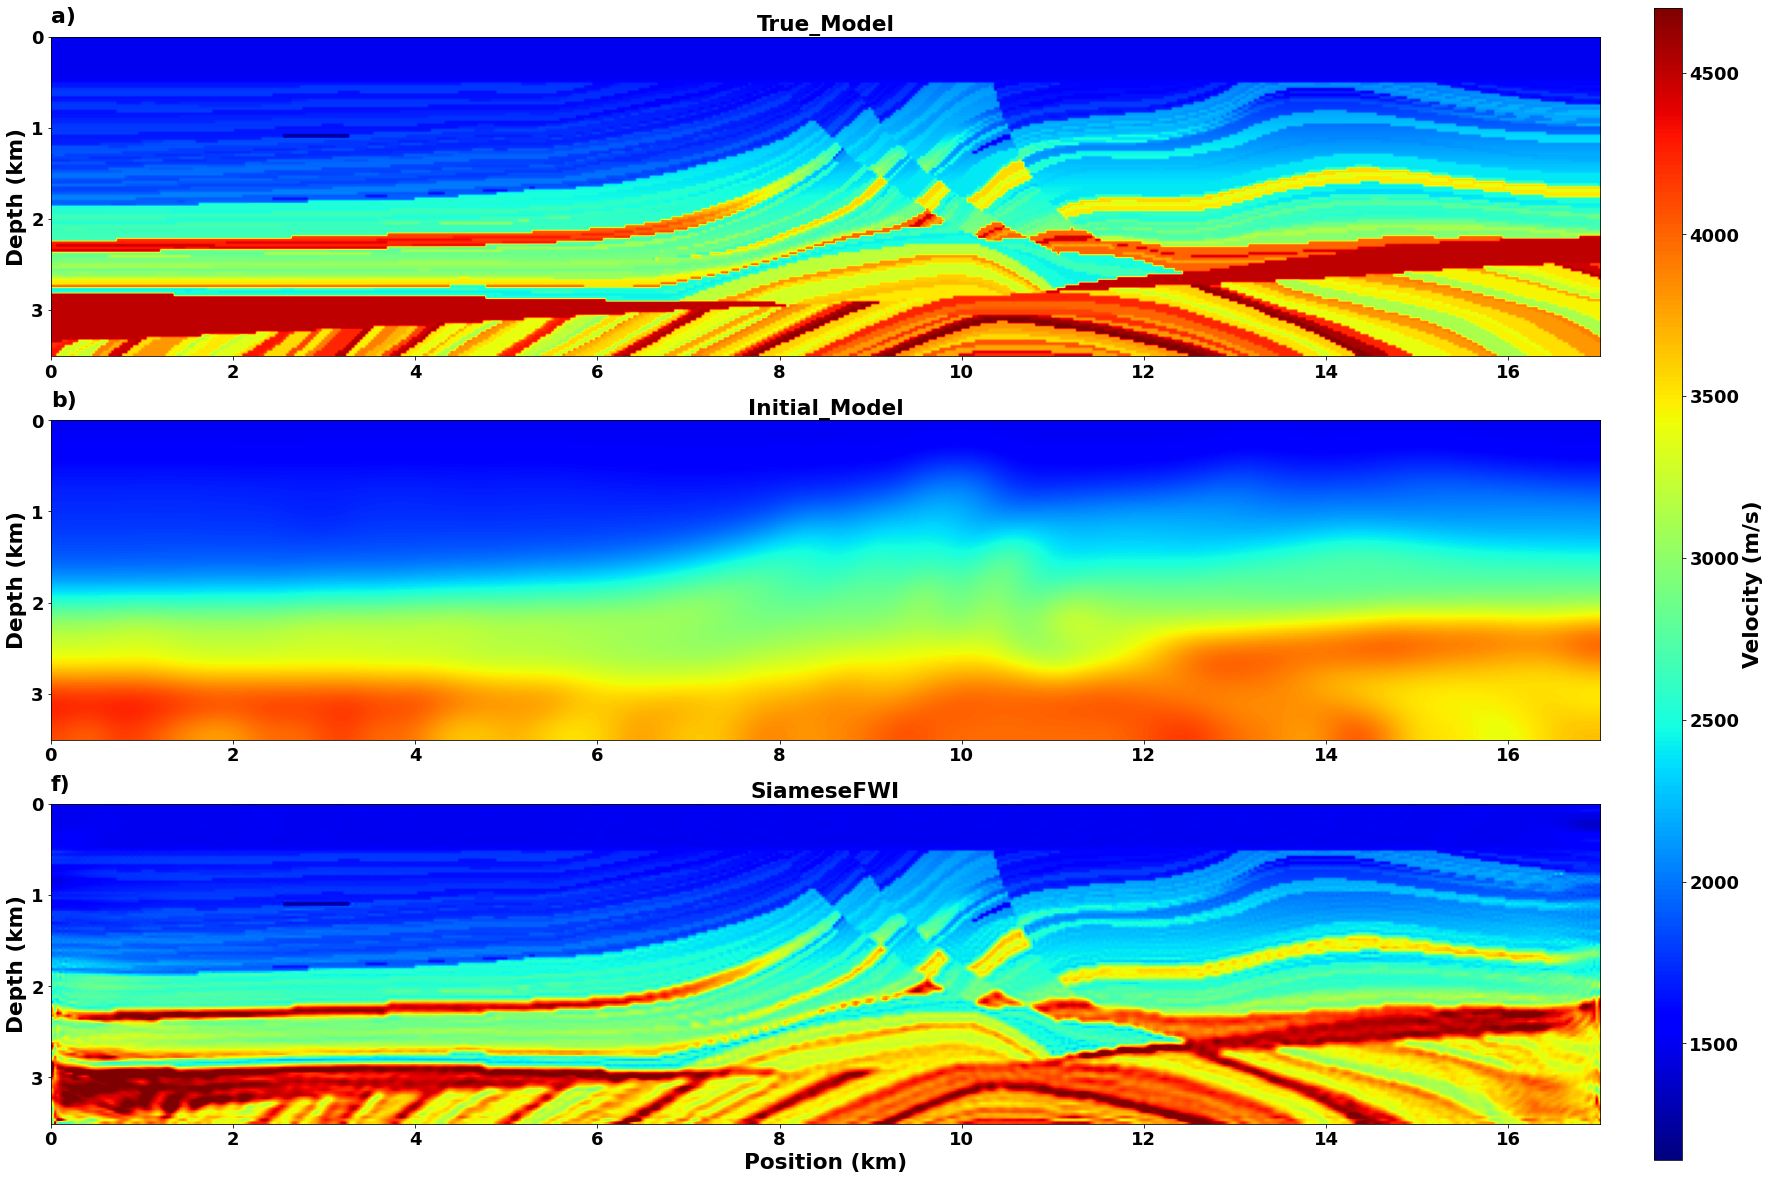

The reconstructed velocity model has SNR: 23.621009280325353 dB and SSIM: 0.8488731


In [11]:
f, ax = plt.subplots(3,1,figsize=(40, 20))
plt.rc('font', **font)

# True Model
modeltrue = model1
im = ax[0].imshow(modeltrue, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modeltrue.shape[1] * dx / 1000, modeltrue.shape[0] * dx / 1000, 0])

#ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('True_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'a)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Initial Model
init_V = model_init
im = ax[1].imshow(init_V, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, init_V.shape[1] * dx / 1000, init_V.shape[0] * dx / 1000, 0])
#ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Siamese Model
Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERec_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[2].imshow(Siamese_Vel, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, Siamese_Vel.shape[1] * dx / 1000, Siamese_Vel.shape[0] * dx / 1000, 0])
ax[2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2].set_title('SiameseFWI',fontsize='large', fontweight='bold')
ax[2].text(0, -0.15, 'f)', fontsize = 22) 
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].set_yticks(np.arange(y.min(), y.max(), 1)) 


cbar_ax = f.add_axes([0.8, 0.1, 0.01, 0.8])
f.colorbar(im, fraction=0.005, pad=0.04,cax=cbar_ax)
cbar_ax.set_ylabel('Velocity (m/s)',fontsize='large', fontweight='bold')

plt.show()

snr = ComputeSNR(Siamese_Vel,  
          model_true.detach().cpu().numpy())

ssim = ComputeSSIM(Siamese_Vel, \
          model_true.detach().cpu().numpy())

print('The reconstructed velocity model has SNR:', str(snr), 'dB', 'and SSIM:',str(ssim.cpu().detach().cpu().numpy()))

## Plotting Velocities Profiles

@Position =  3.6 km, RMSE =  0.17537949002099504 km/s
@Position =  7.2 km, RMSE =  0.13351382882130444 km/s
@Position =  14.4 km, RMSE =  0.09570942098966631 km/s


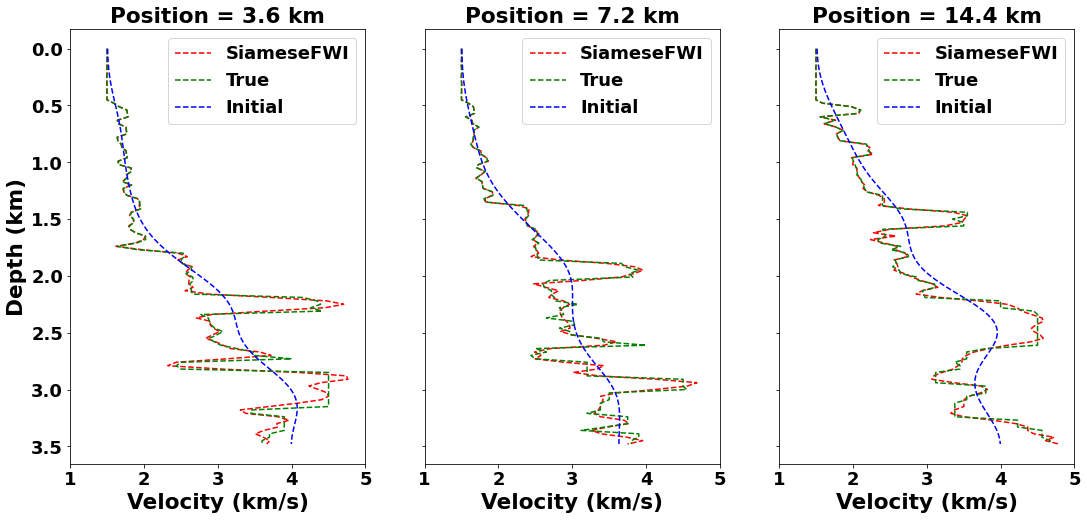

In [12]:
from math import sqrt

# position 1
k = 120

xy = np.arange(0,Siamese_Vel.shape[0] * dx / 1000, len(Siamese_Vel[:,k])/Siamese_Vel.shape[0] * dx / 1000)
f, ax = plt.subplots(figsize=(18, 8), ncols=3,nrows=1)
xx = np.arange(0,4)
ax[0].plot(Siamese_Vel[:,k]/1000,xy,'r--',label='SiameseFWI')
ax[0].plot(modeltrue[:,k]/1000,xy,'g--',label='True')
ax[0].plot(init_V[:,k]/1000,xy,'b--',label='Initial')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_xlabel('Velocity (km/s)',fontsize='large', fontweight='bold')
ax[0].set_xlim([1,5])
ax[0].legend(loc='upper right')
ax[0].set_title( 'Position = ' + str(k * dx / 1000) +' km',fontsize='large', fontweight='bold')
ax[0].invert_yaxis()
rms = sqrt(np.mean(((modeltrue[:,k]-Siamese_Vel[:,k])/1000)**2))
print('@Position = ', str(k * dx / 1000), 'km, RMSE = ',str(rms), 'km/s')

# position 2
k = 240
xy = np.arange(0,Siamese_Vel.shape[0] * dx / 1000, len(Siamese_Vel[:,k])/Siamese_Vel.shape[0] * dx / 1000)
xx = np.arange(0,4)
ax[1].plot(Siamese_Vel[:,k]/1000,xy,'r--',label='SiameseFWI')
ax[1].plot(modeltrue[:,k]/1000,xy,'g--',label='True')
ax[1].plot(init_V[:,k]/1000,xy,'b--',label='Initial')
ax[1].set_xlabel('Velocity (km/s)',fontsize='large', fontweight='bold')
ax[1].set_yticklabels([])
ax[1].set_xlim([1,5])
ax[1].legend(loc='upper right')
ax[1].set_title( 'Position = ' + str(k * dx / 1000) +' km',fontsize='large', fontweight='bold')
ax[1].invert_yaxis()
rms = sqrt(np.mean(((modeltrue[:,k]-Siamese_Vel[:,k])/1000)**2))
print('@Position = ', str(k * dx / 1000), 'km, RMSE = ',str(rms), 'km/s')

# position 3
k = 480
xy = np.arange(0,Siamese_Vel.shape[0] * dx / 1000, len(Siamese_Vel[:,k])/Siamese_Vel.shape[0] * dx / 1000)
xx = np.arange(0,4)
ax[2].plot(Siamese_Vel[:,k]/1000,xy,'r--',label='SiameseFWI')
ax[2].plot(modeltrue[:,k]/1000,xy,'g--',label='True')
#ax[2].plot(FWIGAN_Vel[:,k]/1000,xy,'y--',label='FWIGAN')
ax[2].plot(init_V[:,k]/1000,xy,'b--',label='Initial')
ax[2].set_xlabel('Velocity (km/s)',fontsize='large', fontweight='bold')
ax[2].set_yticklabels([])
ax[2].set_xlim([1,5])
#ax[2].ylim([0,3.8])
ax[2].legend(loc='upper right')
ax[2].set_title( 'Position = ' + str(k * dx / 1000) +' km',fontsize='large', fontweight='bold')
ax[2].invert_yaxis()
rms = sqrt(np.mean(((modeltrue[:,k]-Siamese_Vel[:,k])/1000)**2))
print('@Position = ', str(k * dx / 1000), 'km, RMSE = ',str(rms), 'km/s')

